In [1]:
import ROOT as R
# import numpy as np
import math
import os
import numpy as np

Welcome to JupyROOT 6.22/00


In [2]:
R.gStyle.SetOptStat(0)
R.gStyle.SetGridColor(14)
R.gStyle.SetPadRightMargin(0.05)
R.gStyle.SetPadLeftMargin(0.15)

In [3]:
def draw_nozzle(side=1, scale=1.0, zmax=-1):
    """Draws the contour of the nozzle"""
    # Setting the coordinates of W part in [cm]
    z = [6, 15,    100,   100, 200, 600, 600,  200,   100, 15,  6]
    r = [1, 2.592, 17.63, 15,  17,  50,  1.78, 0.596, 0.3, 0.6, 1]
    # Limiting Z range
    mask = np.ones(len(z), dtype=bool)
    if zmax > 0:
        for i in range(len(z)-1):
            nv = z[i+1]
            # Interpolating at Zmax
            if (z[i] < zmax) == (z[i+1] > zmax):
                idx = i+1 if z[i+1] > z[i] else i
                r[idx] = r[i] + (r[i+1] - r[i]) / (z[i+1] - z[i]) * (zmax - z[i])
                z[idx] = zmax
            # Skipping points outside of Zmax
            elif z[i] > zmax:
                mask[i] = False

    z = np.array(z, dtype=np.float32)
    r = np.array(r, dtype=np.float32)
    z = z[mask]
    r = r[mask]
    # Applying the inversion for the opposite side
    z *= side
    # Applying the scale
    z *= scale
    r *= scale
    # Creating and drawing the polyline
    pol_w = R.TPolyLine(len(z), z, r)
    pol_w.SetFillColor(18)
    return pol_w

## Calculating the mean/max hit mulptiplicities in each layer: VTX

In [3]:
sens_area = {}  # in cm^2
for sub in range(2):
    sens_area.update({('b', l*2+sub): 1e-2*130*a for l, a in enumerate([16*13, 15*23, 21*24, 29*24])})
er_max = 115-3
for sub in range(2):
    sens_area.update({('e', l*2+sub): 1e-2*(math.tan(math.pi/16)*(r+1+er_max+1) + 2*math.sin(math.pi/16))*(er_max-r) for l, r in enumerate([22+3, 28+3, 35+3, 50+3])})


In [4]:
math.pi*(112**2 - 25**2)

37444.642838136744

In [5]:
sens_area

{('b', 0): 270.40000000000003,
 ('b', 2): 448.5,
 ('b', 4): 655.2,
 ('b', 6): 904.8000000000001,
 ('b', 1): 270.40000000000003,
 ('b', 3): 448.5,
 ('b', 5): 655.2,
 ('b', 7): 904.8000000000001,
 ('e', 0): 24.393929747530102,
 ('e', 2): 23.678303870406957,
 ('e', 4): 22.662396759447798,
 ('e', 6): 19.82904213789673,
 ('e', 1): 24.393929747530102,
 ('e', 3): 23.678303870406957,
 ('e', 5): 22.662396759447798,
 ('e', 7): 19.82904213789673}

### Hit multiplicities vs inner layers

In [10]:
# DIR_IN = '/Users/nbartosi/cernbox/work/mu_collider/data'
# DIR_IN = '/Users/nbartosi/pdc/muoncdata/users/bartosik/clic/studies/2022_06_17_vxd_studies'
DIR_IN = '/Users/nbartosi/cernbox/work/mu_collider/data/2023_02_13_vxd_studies'
files_in = [R.TFile(os.path.join(DIR_IN, 'simhit', name)) for name in [
    'mumi_t25ns_n150MeV_v1.0.1_tuple.root',
    'mumi_t25ns_n150MeV_v1.1.1_tuple.root',
]]
trees = [file_in.Get('MyLCTuple') for file_in in files_in]

In [11]:
# Setting Canvas
C = R.TCanvas('canvas', '', 800, 800)
# R.gStyle.SetPalette(R.kBird)
C.SetLeftMargin(0.13)
C.SetRightMargin(0.1)
C.SetGrid(1,1)
DIR_OUT = os.path.join(DIR_IN, 'plots')

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


In [21]:
histos = [R.TH1F(f'h{i:d}', ';Layer;Hits', 10, 0, 10) for i, f in enumerate(files_in)]
gsel = 'abs(sttim - sqrt(stpox*stpox + stpoy*stpoy + stpoz*stpoz)/TMath::C() * 1e6) < 0.18 && stori == 1'
for iT, tree in enumerate(trees):
    tree.Draw(f'int(stci0/128)%64 >> h{iT:d}', f'{gsel}')

Warning in <TFile::Append>: Replacing existing TH1: h0 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h1 (Potential memory leak).


Warning in <TFile::Append>: Replacing existing TH1: h_ax (Potential memory leak).
Info in <TCanvas::Print>: pdf file /Users/nbartosi/cernbox/work/mu_collider/data/2023_02_13_vxd_studies/plots/hit_mult_vxdb.pdf has been created


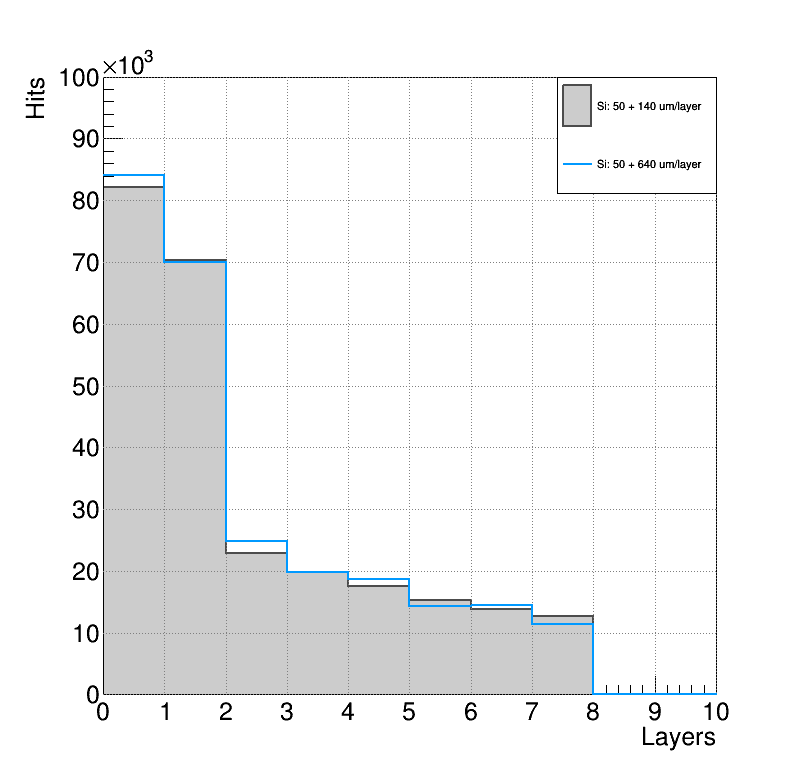

In [23]:
names = [
    'Si: 50 + 140 um/layer',
    'Si: 50 + 640 um/layer',
]
C.Clear()
C.cd()
C.SetGrid(1)
leg = R.TLegend(0.7, 0.75, 0.9, 0.9)
colors = [12, R.kAzure+7, 2, R.kAzure+7, R.kTeal+2]
h_ax = R.TH1F('h_ax', ';Layers;Hits', 10, 0, 10)
h_ax.GetYaxis().SetMaxDigits(3)
h_ax.SetAxisRange(0, 100e3, 'Y')
h_ax.Draw('AXIS')
h_ax.Draw('AXIG same')
for iT, tree in enumerate(trees):
    h = histos[iT]
#     h.SetDirectory(0)
    h.SetLineColor(colors[iT])
    h.SetLineWidth(2)
    leg_type = 'L'
    if iT == 0:
        h.SetFillColor(17)
        leg_type = 'F'
    leg.AddEntry(h, names[iT], leg_type)
    h.Draw('same')
    if iT == 0:
        h_ax.Draw('AXIG same')
leg.Draw()
C.Draw()
C.SaveAs(os.path.join(DIR_OUT, 'hit_mult_vxdb.pdf'))

### Hit multiplicities vs Magnetic field

In [28]:
files_in = [R.TFile(os.path.join(DIR_IN, 'bib_simhit', name)) for name in [
    'mumi_t25ns_n150MeV_MuColl_v1_vxd_mcp.root',
    'mumi_t25ns_n150MeV_MuColl_v1_mod2_vxd_mcp.root'
]]
trees = [file_in.Get('tree') for file_in in files_in]

In [29]:
histos = [R.TH1F(f'h{i:d}', ';Layer;Hits', 10, 0, 10) for i, f in enumerate(files_in)]
gsel = 'abs(time - time0) < 0.18'
for iT, tree in enumerate(trees):
    tree.Draw(f'layer >> h{iT:d}', f'col_id == 0 && {gsel}')

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file /Users/nbartosi/cernbox/work/mu_collider/data/2022_06_17_vxd_studies/plots/nhits_mag_field_vxdb.pdf has been created


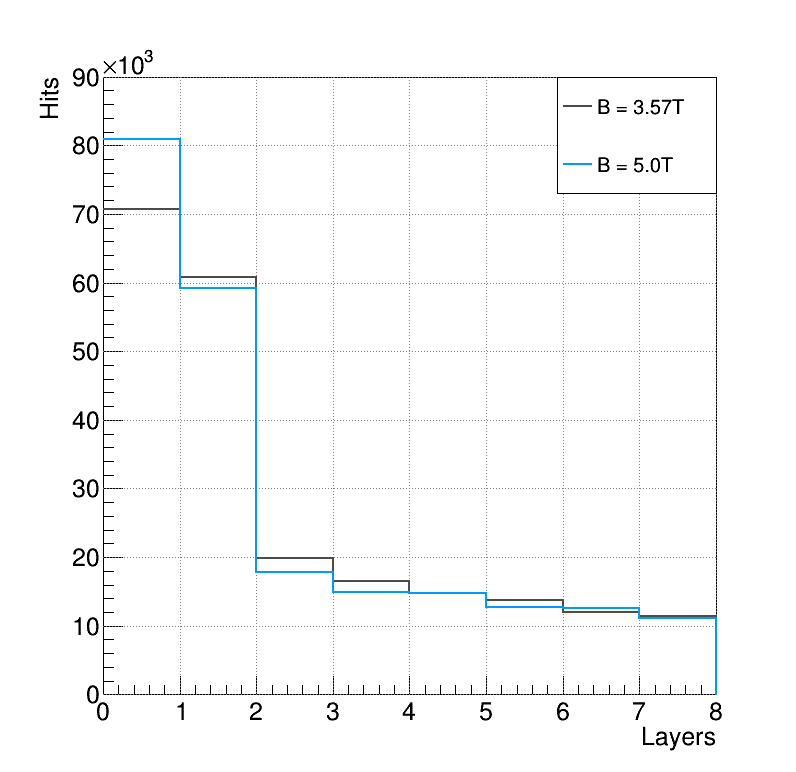

In [30]:
names = [
    'B = 3.57T',
    'B = 5.0T',
]
# Setting Canvas
C = R.TCanvas('canvas', '', 800, 800)
# R.gStyle.SetPalette(R.kBird)
C.SetLeftMargin(0.13)
C.SetRightMargin(0.1)
C.SetGrid(1,1)
leg = R.TLegend(0.7, 0.75, 0.9, 0.9)
colors = [12, R.kAzure+7, 2, R.kAzure+7, R.kTeal+2]
h_ax = R.TH1F('h_ax', ';Layers;Hits', 10, 0, 8)
h_ax.SetAxisRange(0, 9e4, 'Y')
h_ax.GetYaxis().SetMaxDigits(3)
h_ax.Draw('AXIS')
h_ax.Draw('AXIG same')
for iT, tree in enumerate(trees):
    h = histos[iT]
#     h.SetDirectory(0)
    h.SetLineColor(colors[iT])
    h.SetLineWidth(2)
    leg.AddEntry(h, names[iT], 'L')
    h.Draw('same')
leg.Draw()
C.Draw()
C.SaveAs(os.path.join(DIR_OUT, 'nhits_mag_field_vxdb.pdf'))

### 2D hit maps

In [4]:
DIR_IN = '/Users/nbartosi/cernbox/work/mu_collider/data/2022_06_17_vxd_studies'
DIR_OUT = os.path.join(DIR_IN, 'plots')
files_in = [R.TFile(os.path.join(DIR_IN, 'bib_simhit', name)) for name in [
    'mumi_t25ns_n150MeV_MuColl_v1_vxd_mcp.root',
    'mumi_t25ns_n150MeV_MuColl_v1_mod2_vxd_mcp.root'
]]
trees = [file_in.Get('tree') for file_in in files_in]

Warning in <TFile::Append>: Replacing existing TH1: h0 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file /Users/nbartosi/cernbox/work/mu_collider/data/2022_06_17_vxd_studies/plots/hit_density_2d_vxde0_geo0.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file /Users/nbartosi/cernbox/work/mu_collider/data/2022_06_17_vxd_studies/plots/hit_density_2d_vxde0_geo1.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file /Users/nbartosi/cernbox/work/mu_collider/data/2022_06_17_vxd_studies/plots/hit_density_2d_vxde1_geo0.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file /Users/nbartosi/cernbox/work/mu_collid

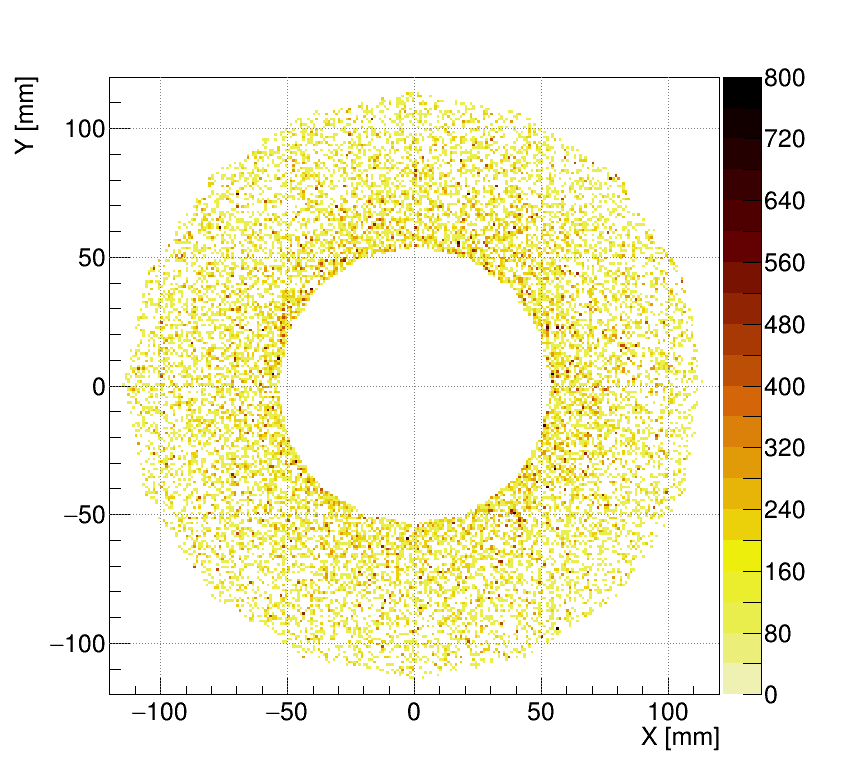

In [8]:
R.gStyle.SetPalette(R.kInvertedDarkBodyRadiator)
histos = [R.TH2F(f'h{i:d}', ';X [mm];Y [mm]', 240, -120, 120, 240, -120, 120) for i, f in enumerate(files_in)]
# gsel = 'abs(time - time0) < 0.18'
gsel = 'time - time0 < 0.18'
# gsel = 'pos_r > 0'
zmax = [2500, 4000, 1500, 800]
for layer in range(8):
    for iT, tree in enumerate(trees):
        tree.Draw(f'pos_x:pos_y >> h{iT:d}', f'col_id == 1 && layer == {layer} && {gsel}')
        C = R.TCanvas('canvas', '', 850, 800)
        C.SetLeftMargin(0.13)
        C.SetRightMargin(0.15)
        C.SetGrid(1,1)
        h = histos[iT]
        # Normalizing to have hit density in cm^-2 on Z axis
        h.Scale(1e2)
        h.SetAxisRange(0, zmax[int(layer/2)], 'Z')
        h.Draw('colz cjust')
        C.SaveAs(os.path.join(DIR_OUT, f'hit_density_2d_vxde{layer}_geo{iT}.pdf'))
C.Draw()

### Hit time vs Magnetic field

In [55]:
files_in = [R.TFile(os.path.join(DIR_IN, 'bib_simhit', name)) for name in [
    'mumi_t25ns_n150MeV_MuColl_v1_vxd_mcp.root',
    'mumi_t25ns_n150MeV_MuColl_v1_mod2_vxd_mcp.root'
]]
trees = [file_in.Get('tree') for file_in in files_in]

In [103]:
histos = [R.TH1F(f'h{i:d}', '', 400, -10, 10) for i, f in enumerate(files_in)]
for iT, tree in enumerate(trees):
    tree.Draw(f'time - time0 >> h{iT:d}', f'col_id == 1 && layer == 2')

Warning in <TFile::Append>: Replacing existing TH1: h0 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h1 (Potential memory leak).


Warning in <TFile::Append>: Replacing existing TH1: h_ax (Potential memory leak).


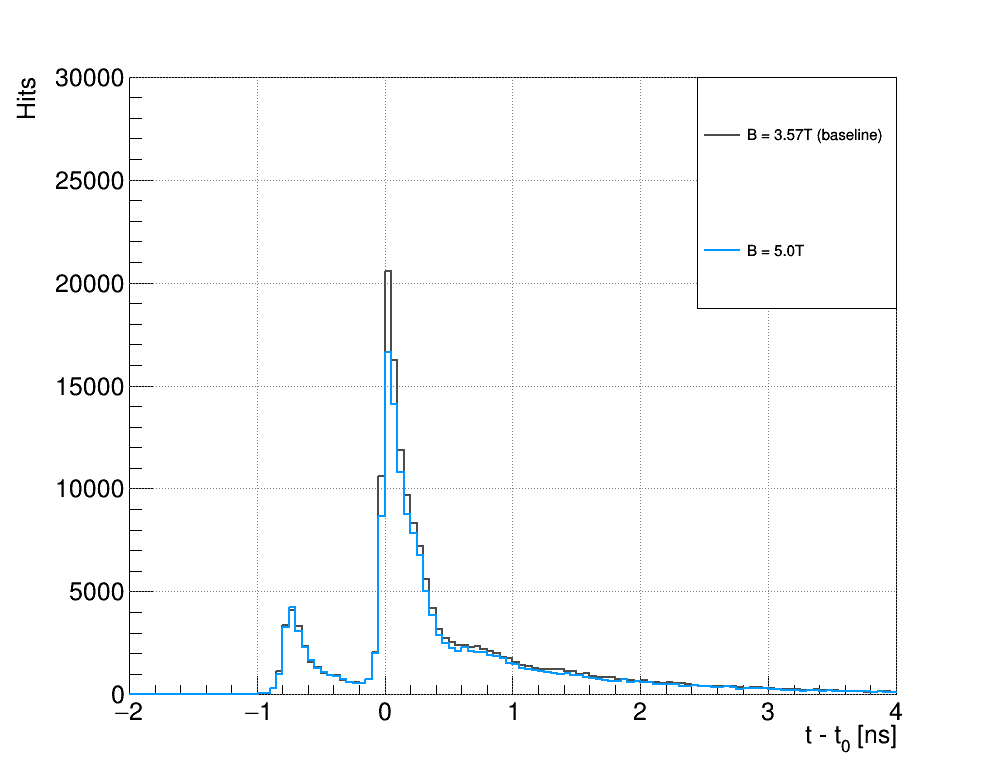

In [109]:
names = [
    'B = 3.57T (baseline)',
    'B = 5.0T',
]
C.Clear()
C.cd()
C.SetGrid(1)
C.SetLogy(False)
leg = R.TLegend(0.7, 0.6, 0.9, 0.9)
colors = [12, R.kAzure+7, 2, R.kAzure+7, R.kTeal+2]
h_ax = R.TH1F('h_ax', ';t - t_{0} [ns];Hits', 10, -2, 4)
h_ax.SetAxisRange(0, 3e4, 'Y')
h_ax.Draw('AXIS')
h_ax.Draw('AXIG same')
for iT, tree in enumerate(trees):
    h = histos[iT]
#     h.SetDirectory(0)
    h.SetLineColor(colors[iT])
    h.SetLineWidth(2)
    leg.AddEntry(h, names[iT], 'L')
    h.Draw('same')
leg.Draw()
C.Draw()
#     C.SaveAs(os.path.join(DIR_OUT, 'pos_xy_'+sel_name+'.png'))

### Drawing the hit and MCParticle vertex positions

In [78]:
file_in = R.TFile(os.path.join(DIR_IN, 'bib_simhit', 'mumi_t25ns_n150MeV_MuColl_v1_vxd_mcp.root'))
tree = file_in.Get('tree')

In [159]:
RNG = {'x': 300, 'y': 120}
NH = 3
histos = [R.TH2F('h{0:d}'.format(i), ';Z [mm];R [mm]', 5*RNG['x'],-RNG['x'],RNG['x'], 5*RNG['y'],0,RNG['y']) for i in range(NH)]
# Setting Canvas
C = R.TCanvas('canvas', '', 1200, 600)
C.SetLeftMargin(0.1)
C.SetRightMargin(0.1)
C.SetGrid(1,1)
C.SetLogz(True)
R.gStyle.SetPalette(R.kRainBow)
# R.TColor.InvertPalette()

Warning in <TFile::Append>: Replacing existing TH1: h0 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h2 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


Info in <TCanvas::Print>: png file /Users/nbartosi/cernbox/work/mu_collider/data/2022_06_17_vxd_studies/plots/pos_rz_vxd_hit.png has been created
Info in <TCanvas::Print>: png file /Users/nbartosi/cernbox/work/mu_collider/data/2022_06_17_vxd_studies/plots/pos_rz_vxd_mcp.png has been created
Info in <TCanvas::Print>: png file /Users/nbartosi/cernbox/work/mu_collider/data/2022_06_17_vxd_studies/plots/pos_rz_vxd_mcp_bib.png has been created
Info in <TCanvas::Print>: png file /Users/nbartosi/cernbox/work/mu_collider/data/2022_06_17_vxd_studies/plots/pos_rz_vxdb_l01_hit.png has been created
Info in <TCanvas::Print>: png file /Users/nbartosi/cernbox/work/mu_collider/data/2022_06_17_vxd_studies/plots/pos_rz_vxdb_l01_mcp.png has been created
Info in <TCanvas::Print>: png file /Users/nbartosi/cernbox/work/mu_collider/data/2022_06_17_vxd_studies/plots/pos_rz_vxdb_l01_mcp_bib.png has been created
Info in <TCanvas::Print>: png file /Users/nbartosi/cernbox/work/mu_collider/data/2022_06_17_vxd_studi

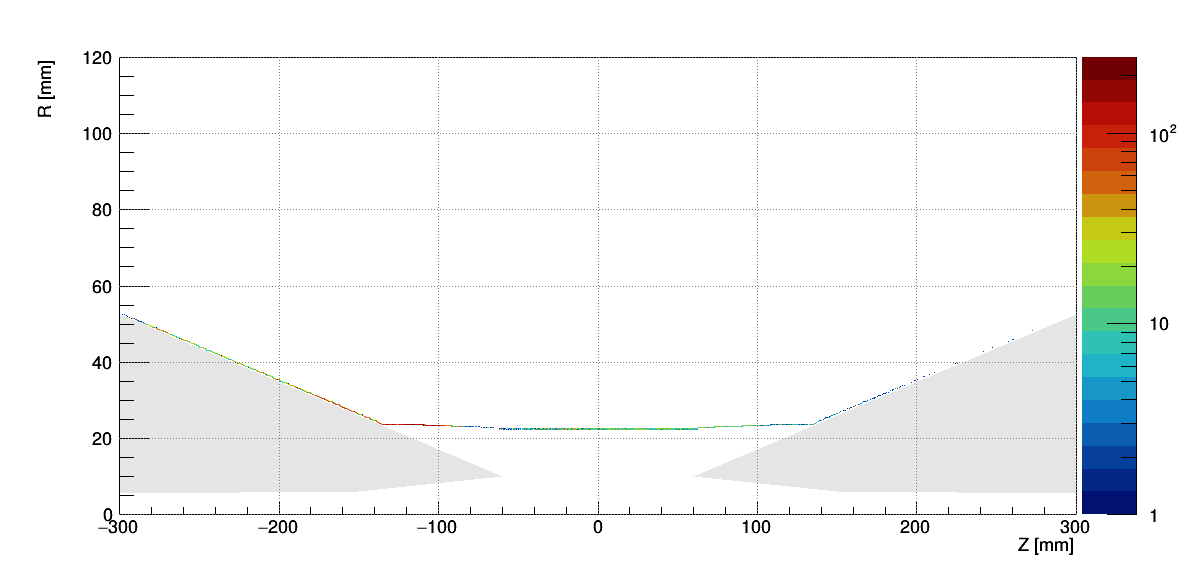

In [160]:
gsel = 'abs(time - time0) < 0.18'
sels = {
    'vxd': 'col_id <= 1',
    'vxdb_l01': 'col_id == 0 && layer <= 1',
    'vxdb_l23': 'col_id == 0 && (layer == 2 || layer == 3)',
    'vxdb_l67': 'col_id == 0 && layer >= 6',
    'vxde_l01': 'col_id == 1 && layer <= 1',
    'vxde_l23': 'col_id == 1 && (layer == 2 || layer == 3)',
    'vxde_l67': 'col_id == 1 && layer >= 6',
    'vxde_l01m': 'col_id == 1 && layer <= 1 && side < 0',
    'vxde_l23m': 'col_id == 1 && (layer == 2 || layer == 3) && side < 0',
    'vxde_l67m': 'col_id == 1 && layer >= 6 && side < 0',
}

zmax = [2e3, 2e2]
hnames = ['hit', 'mcp', 'mcp_bib']
hlegs = ['Hits', 'Particles', 'BIB particles']
colors = [12, R.kAzure+7, 2, R.kAzure+7, R.kTeal+2]
for sel_name, sel in sels.items():
    # 2D histograms
    for h in histos:
        h.Reset('M')
    tree.Draw('pos_r:pos_z >> h0', sel+' && '+gsel, 'goff')
    tree.Draw('mcp_vtx_r:mcp_vtx_z >> h1', sel+' && '+gsel, 'goff')
    tree.Draw('mcp_bib_vtx_r:mcp_bib_vtx_z >> h2', sel+' && '+gsel, 'goff')
    for i in [1, 2]:
        histos[i].SetAxisRange(1, histos[2].GetMaximum(), 'Z')
    C.Clear()
    C.cd()
    n_total = sum([h.GetEntries() for h in histos])
    for iH, hId in enumerate([0, 1, 2]):
        h = histos[hId]
        h.Draw('AXIS')
        nozzle_r = draw_nozzle(1, 10, zmax=30)
        nozzle_l = draw_nozzle(-1, 10, zmax=30)
        nozzle_r.Draw('F')
        nozzle_l.Draw('F')
        h.Draw('AXIS same')
        h.Draw('colz same')
        C.SaveAs(os.path.join(DIR_OUT, f'pos_rz_{sel_name}_{hnames[iH]}.png'))
        C.Draw()
            

### Drawing the MCParticle angles

In [171]:
RNG = {'x': 300, 'y': 90}
NH = 2
histos = [R.TH2F('h{0:d}'.format(i), ';Z [mm];#Theta [rad]', 5*RNG['x'],-RNG['x'],RNG['x'], int(2*RNG['y']),-RNG['y'],RNG['y']) for i in range(NH)]
# Setting Canvas
C = R.TCanvas('canvas', '', 1200, 600)
C.SetLeftMargin(0.1)
C.SetRightMargin(0.1)
C.SetGrid(1,1)
C.SetLogz(True)
R.gStyle.SetPalette(R.kRainBow)
# R.TColor.InvertPalette()

Warning in <TFile::Append>: Replacing existing TH1: h0 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


Info in <TCanvas::Print>: png file /Users/nbartosi/cernbox/work/mu_collider/data/2022_06_17_vxd_studies/plots/theta_z_vxd_mcp.png has been created
Info in <TCanvas::Print>: png file /Users/nbartosi/cernbox/work/mu_collider/data/2022_06_17_vxd_studies/plots/theta_z_vxd_mcp_bib.png has been created
Info in <TCanvas::Print>: png file /Users/nbartosi/cernbox/work/mu_collider/data/2022_06_17_vxd_studies/plots/theta_z_vxdb_l01_mcp.png has been created
Info in <TCanvas::Print>: png file /Users/nbartosi/cernbox/work/mu_collider/data/2022_06_17_vxd_studies/plots/theta_z_vxdb_l01_mcp_bib.png has been created
Info in <TCanvas::Print>: png file /Users/nbartosi/cernbox/work/mu_collider/data/2022_06_17_vxd_studies/plots/theta_z_vxdb_l23_mcp.png has been created
Info in <TCanvas::Print>: png file /Users/nbartosi/cernbox/work/mu_collider/data/2022_06_17_vxd_studies/plots/theta_z_vxdb_l23_mcp_bib.png has been created
Info in <TCanvas::Print>: png file /Users/nbartosi/cernbox/work/mu_collider/data/2022_

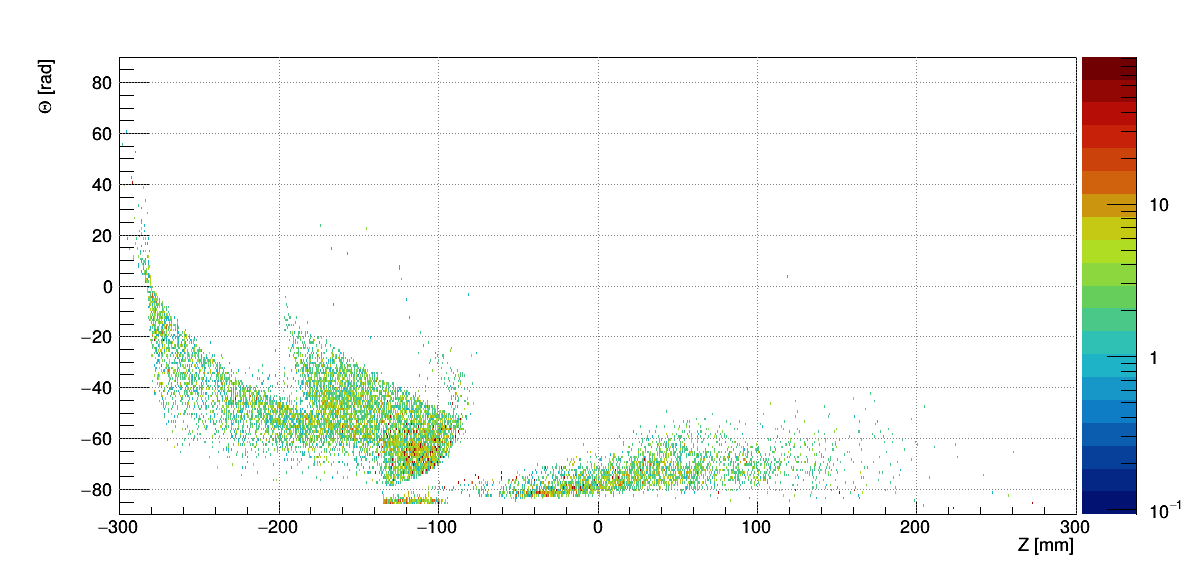

In [173]:
gsel = 'abs(time - time0) < 0.18'
sels = {
    'vxd': 'col_id <= 1',
    'vxdb_l01': 'col_id == 0 && layer <= 1',
    'vxdb_l23': 'col_id == 0 && (layer == 2 || layer == 3)',
    'vxdb_l67': 'col_id == 0 && layer >= 6',
    'vxde_l01': 'col_id == 1 && layer <= 1',
    'vxde_l23': 'col_id == 1 && (layer == 2 || layer == 3)',
    'vxde_l67': 'col_id == 1 && layer >= 6',
    'vxde_l01m': 'col_id == 1 && layer <= 1 && side < 0',
    'vxde_l23m': 'col_id == 1 && (layer == 2 || layer == 3) && side < 0',
    'vxde_l67m': 'col_id == 1 && layer >= 6 && side < 0',
}

zmax = [2e3, 2e2]
hnames = ['mcp', 'mcp_bib']
for sel_name, sel in sels.items():
    for h in histos:
        h.Reset('M')
    tree.Draw('-180.0/3.141593*TMath::ATan2(mcp_pt, mcp_pz) + 90:mcp_vtx_z >> h0', sel+' && '+gsel, 'goff')
    tree.Draw('-180.0/3.141593*TMath::ATan2(mcp_bib_pt, mcp_bib_pz) + 90:mcp_bib_vtx_z >> h1', sel+' && '+gsel, 'goff')
    C.Clear()
    C.cd()
    leg = R.TLegend(0.4, 0.8, 0.95, 0.9)
    leg.SetNColumns(NH)
    n_total = sum([h.GetEntries() for h in histos])
    for iH, hId in enumerate([0, 1]):
        h = histos[hId]
        h.Draw('colz')
        draw_nozzle(1)
        draw_nozzle(-1)
        C.SaveAs(os.path.join(DIR_OUT, f'theta_z_{sel_name}_{hnames[iH]}.png'))
        C.Draw()

### Drawing the hit and MCParticle vertex positions

In [32]:
RNG = {'x': 300, 'y': 150}
NH = 3
histos = [R.TH2I('h{0:d}'.format(i), ';Z [mm];R [mm]', 200*RNG['x'],-RNG['x'],RNG['x'], 100*RNG['y'],0,RNG['y']) for i in range(NH)]
# Setting Canvas
C = R.TCanvas('canvas', '', 1200, 600)
R.gStyle.SetPalette(R.kBird)
C.SetLeftMargin(0.1)
C.SetRightMargin(0.05)
C.SetGrid(1,1)
DIR_OUT = '/Users/nbartosi/pdc/muoncdata/users/bartosik/clic/studies/2020_12_22_tracking/plots'

Warning in <TFile::Append>: Replacing existing TH1: h0 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


Info in <TCanvas::Print>: png file /Users/nbartosi/pdc/muoncdata/users/bartosik/clic/studies/2020_12_22_tracking/plots/pos_rz_vxdb_l23.png has been created


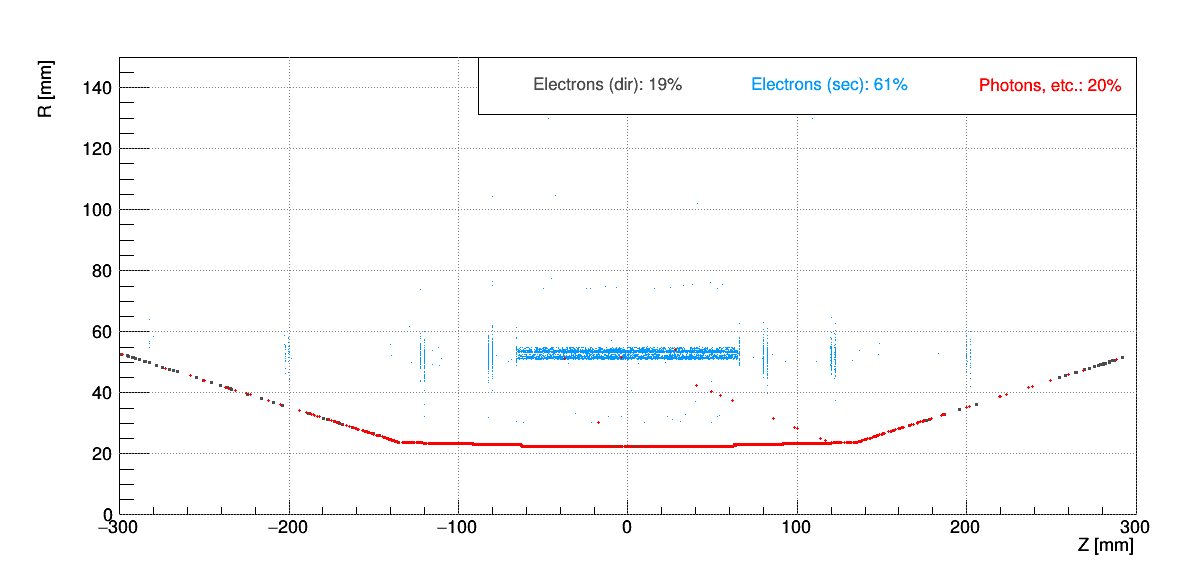

In [45]:
gsel = 'abs(time - time0) < 0.18'
sels = {
#     'vxdb_l01': 'col_id == 0 && layer <= 1',
    'vxdb_l23': 'col_id == 0 && (layer == 2 || layer == 3)',
#     'vxdb_l67': 'col_id == 0 && layer >= 6',
#     'vxde_l01': 'col_id == 1 && layer <= 1 && side == 1',
#     'vxde_l23': 'col_id == 1 && (layer == 2 || layer == 3) && side == 1',
#     'vxde_l67': 'col_id == 1 && layer >= 6 && side == 1',
}
# sels = {
#     'eb': 'col_id == 0',
#     'hb': 'col_id == 2',
# }
colors = [ 12, R.kAzure+7, 2]
markers = [7, 1, 6]
legs = ['Electrons (dir)', 'Electrons (sec)', 'Photons, etc.']
for iH, h in enumerate(histos):
    h.SetMarkerColor(colors[iH])
    h.SetMarkerStyle(markers[iH])
for sel_name, sel in sels.items():
#     trees[0].Draw('pos_r:pos_z >> h0', sel+' && '+gsel)
    trees[0].Draw('mcp_vtx_r:mcp_vtx_z >> h0', sel+' && abs(mcp_pdg) == 11 && mcp_bib_niters == 0 && '+gsel, 'goff')
    trees[0].Draw('mcp_vtx_r:mcp_vtx_z >> h1', sel+' && abs(mcp_pdg) == 11 && mcp_bib_niters > 0 && '+gsel, 'goff')
    trees[0].Draw('mcp_vtx_r:mcp_vtx_z >> h2', sel+' && abs(mcp_pdg) != 11 && '+gsel, 'goff')
    C.Clear()
    C.cd()
    leg = R.TLegend(0.4, 0.8, 0.95, 0.9)
    leg.SetNColumns(NH)
    n_total = sum([h.GetEntries() for h in histos])
    for iH, hId in enumerate([0,1,2]):
        drawopt = '' if iH == 0 else 'same'
        h = histos[hId]
#         if iH == 0:
#             h.SetAxisRange(-150, 150, 'X')
#             h.SetAxisRange(22, 24.0, 'Y')
        h.Draw(drawopt)
        leg.AddEntry(h, legs[hId] + ': {0:.0f}%'.format(h.GetEntries()/n_total*100), '').SetTextColor(colors[hId])
    leg.Draw()
    C.Draw()
    C.SaveAs(os.path.join(DIR_OUT, 'pos_rz_'+sel_name+'.png'))

### Drawing the particle momenta

In [59]:
RNG = {'x': 50}
NH = 3
histos = [R.TH1F('h{0:d}'.format(i), ';Momentum [MeV];Partiles', 200,0,RNG['x']) for i in range(NH)]
# Setting Canvas
C = R.TCanvas('canvas', '', 600, 600)
C.SetTopMargin(0.05)
C.SetLeftMargin(0.12)
C.SetRightMargin(0.05)
C.SetGrid(1,1)
DIR_OUT = '/Users/nbartosi/pdc/muoncdata/users/bartosik/clic/studies/2020_12_22_tracking/plots'

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


vxde_l45
29330
34910
42470


Info in <TCanvas::Print>: png file /Users/nbartosi/pdc/muoncdata/users/bartosik/clic/studies/2020_12_22_tracking/plots/mcp_p_bib_trk_vxde_l45.png has been created


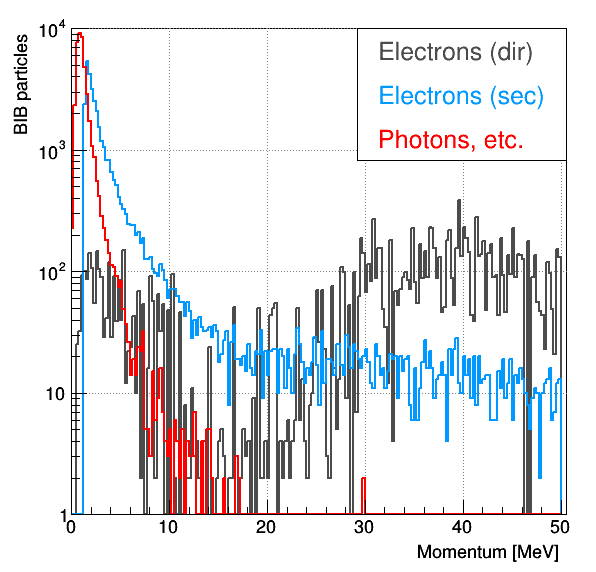

In [79]:
# gsel = 'abs(mcp_bib_pdg) == 11'
gsel = 'abs(time - time0) < 0.18'
sels = {
#     'electrons_40': 'abs(mcp_pdg) == 11 && layer == 1 && mcp_p*1e3 > 40.0',
#     'electrons_20': 'abs(mcp_pdg) == 11 && layer == 1 && mcp_p*1e3 > 20.0',
#     'electrons_10': 'abs(mcp_pdg) == 11 && layer == 1 && mcp_p*1e3 > 10.0',
#     'electrons_5': 'abs(mcp_pdg) == 11 && layer == 1 && mcp_p*1e3 > 5.0',
#     'electrons_0': 'abs(mcp_pdg) == 11 && layer == 1',
#     'all': 'layer == 1',
#     'vxdb_l01': 'col_id == 0 && layer <= 1',
#     'vxdb_l23': 'col_id == 0 && (layer == 2 || layer == 3)',
#     'vxde_l23': 'col_id == 1 && (layer == 2 || layer == 3) && side == 1',
    'vxde_l45': 'col_id == 1 && (layer == 4 || layer == 5) && side == 1',
#     'vxdb_l67': 'col_id == 0 && layer >= 6',
#     'vxde_l01': 'col_id == 1 && layer <= 1 && side == 1',
#     'vxde_l67': 'col_id == 1 && layer >= 6 && side == 1',
}
# colors = [12, R.kAzure+7, 2, R.kAzure+7, R.kTeal+2]
# legs = ['Vertex Detector', 'Inner Tracker', 'Outer Tracker']
colors = [ 12, R.kAzure+7, 2]
legs = ['Electrons (dir)', 'Electrons (sec)', 'Photons, etc.']
for iH, h in enumerate(histos):
    h.SetLineColor(colors[iH])
    h.SetLineWidth(2)

for sel_name, sel in sels.items():
    h_axis = R.TH1I('h_axis', ';Momentum [MeV];BIB particles', 100, 0, RNG['x'])
    h_axis.SetAxisRange(1, 1e4, 'Y')
    h_axis.SetAxisRange(0, 100, 'X')
    h_axis.GetXaxis().SetTitleOffset(1.2)
    h_axis.SetDirectory(0)
    # Drawing the tree
#     n_vb = trees[0].Draw('mcp_p*1e3 >> h0', '(col_id == 0) && (time - time0) > -0.18 && (time - time0) < 0.18 && '+sel)
#     n_ib = trees[0].Draw('mcp_p*1e3 >> h1', '(col_id == 2) && (time - time0) > -0.36 && (time - time0) < 1.36 && '+sel)
#     n_ob = trees[0].Draw('mcp_p*1e3 >> h2', '(col_id == 4) && (time - time0) > -0.36 && (time - time0) < 1.36 && '+sel)
#     print(sel_name, n_vb, n_ib, n_ob)
    print(sel_name)
    print(trees[0].Draw('mcp_p*1e3 >> h0', sel+'&& abs(mcp_pdg) == 11 && mcp_bib_niters == 0 && '+gsel, 'goff'))
    print(trees[0].Draw('mcp_p*1e3 >> h1', sel+'&& abs(mcp_pdg) == 11 && mcp_bib_niters > 0 && '+gsel, 'goff'))
    print(trees[0].Draw('mcp_p*1e3 >> h2', sel+'&& abs(mcp_pdg) != 11 && '+gsel, 'goff'))
    C.Clear()
    C.cd()
    leg = R.TLegend(0.6, 0.72, 0.95, 0.95)
#     leg.SetNColumns(NH)
    leg.SetMargin(0.1)
#     leg.SetFillStyle(0)
#     leg.SetBorderSize(0)
    h_axis.Draw('AXIS')
    h_axis.Draw('AXIG same')
    for iH, h in enumerate(histos):
#         h.Scale(1.0/h.GetEntries())
        h.Draw('HIST same')
        leg.AddEntry(h, legs[iH], '').SetTextColor(colors[iH])
    leg.Draw()
    C.SetLogy()
    C.RedrawAxis()
    C.Draw()
    C.SaveAs(os.path.join(DIR_OUT, 'mcp_p_bib_trk_'+sel_name+'.png'))

### Drawing the Hit Deposited Energy

In [4]:
RNG = {'x': 0.5}
NH = 3
histos = [R.TH1F('h{0:d}'.format(i), ';Deposited energy [KeV];Hits', 5000,0,RNG['x']) for i in range(NH)]
# Setting Canvas
C = R.TCanvas('canvas', '', 1200, 600)
C.SetTopMargin(0.05)
C.SetLeftMargin(0.1)
C.SetRightMargin(0.02)
C.SetGrid(1,1)
DIR_OUT = '/Users/nbartosi/pdc/muoncdata/users/bartosik/clic/studies/2020_12_22_tracking/plots'

In [5]:
x_elec = np.array([0.00010, 0.00011, 0.00013, 0.00014, 0.00015, 0.00017, 0.00018, 0.00020, 0.00022, 0.00024, 0.00026, 0.00029, 0.00032, 0.00035, 0.00038, 0.00042, 0.00046, 0.00050, 0.00055, 0.00060, 0.00066, 0.00072, 0.00079, 0.00087, 0.00095, 0.00105, 0.00115, 0.00126, 0.00138, 0.00151, 0.00166, 0.00182, 0.00200, 0.00219, 0.00240, 0.00263, 0.00288, 0.00316, 0.00347, 0.00380, 0.00417, 0.00457, 0.00501, 0.00550, 0.00603, 0.00661, 0.00724, 0.00794, 0.00871, 0.00955, 0.01047, 0.01148, 0.01259, 0.01380, 0.01514, 0.01660, 0.01820, 0.01995, 0.02188, 0.02399, 0.02630, 0.02884, 0.03162, 0.03467, 0.03802, 0.04169, 0.04571, 0.05012, 0.05495, 0.06026, 0.06607, 0.07244, 0.07943, 0.08710, 0.09550, 0.10471, 0.11482, 0.12589, 0.13804, 0.15136, 0.16596, 0.18197, 0.19953, 0.21878, 0.23988, 0.26303, 0.28840, 0.31623, 0.34674, 0.38019, 0.41687, 0.45709, 0.50119, 0.54954, 0.60256, 0.66069, 0.72444, 0.79433, 0.87096, 0.95499], dtype=np.float32)
y_elec = np.array([0.00000, 0.00003, 0.00010, 0.00023, 0.00041, 0.00064, 0.00092, 0.00125, 0.00163, 0.00207, 0.00255, 0.00309, 0.00368, 0.00455, 0.00542, 0.00628, 0.00715, 0.00803, 0.00895, 0.00988, 0.01081, 0.01178, 0.01282, 0.01387, 0.01491, 0.01606, 0.01732, 0.01857, 0.01983, 0.02109, 0.02234, 0.02360, 0.02488, 0.02630, 0.02775, 0.02919, 0.03064, 0.03214, 0.03368, 0.03522, 0.03675, 0.03829, 0.03984, 0.04142, 0.04300, 0.04459, 0.04616, 0.04771, 0.04927, 0.05082, 0.05232, 0.05375, 0.05519, 0.05663, 0.05806, 0.05950, 0.06094, 0.06235, 0.06360, 0.06483, 0.06605, 0.06728, 0.06838, 0.06940, 0.07042, 0.07143, 0.07245, 0.07344, 0.07425, 0.07505, 0.07584, 0.07657, 0.07718, 0.07779, 0.07840, 0.07886, 0.07917, 0.07948, 0.07980, 0.08011, 0.08042, 0.08074, 0.08098, 0.08098, 0.08098, 0.08098, 0.08098, 0.08098, 0.08098, 0.08098, 0.08098, 0.08098, 0.08098, 0.08098, 0.08098, 0.08098, 0.08098, 0.08098, 0.08098, 0.08098], dtype=np.float32)
zeros = np.zeros(len(x_elec), dtype=np.float32)
g_elec = R.TGraphErrors(len(x_elec), x_elec, y_elec, zeros, zeros)

1228829.0 1228829


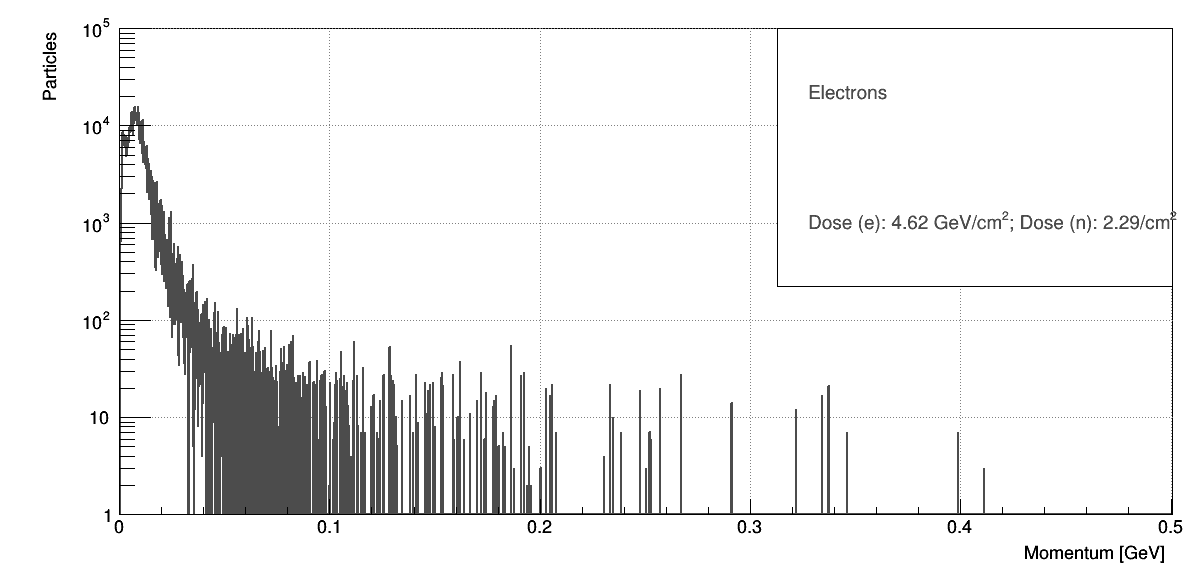

In [11]:
pdgIds = [11]
areas = [270.40, 8117.85, 140032.91]
area = areas[0]
colors = [12, R.kAzure+7, 2, R.kAzure+7, R.kTeal+2]
legs = ['Electrons', 'Protons', 'Pions']
for iH, h in enumerate(histos):
    h.SetLineColor(colors[iH])
    h.SetLineWidth(2)
#     h.SetDirectory(0)
#     R.SetOwnership(h, False)

h_axis = R.TH1I('h_axis', ';Momentum [GeV];Particles', 1000, 0, RNG['x'])
h_axis.SetAxisRange(1, 1e5, 'Y')
h_axis.SetAxisRange(0, 500, 'X')
h_axis.GetXaxis().SetTitleOffset(1.2)
h_axis.SetDirectory(0)
C.Clear()
C.cd()
leg = R.TLegend(0.65, 0.5, 0.98, 0.95)
leg.SetMargin(0.08)
# leg.SetFillStyle(0)
# leg.SetBorderSize(0)
h_axis.Draw('AXIS')
h_axis.Draw('AXIG same')
for iP, pdgId in enumerate(pdgIds):
    # Drawing the tree
    nev = trees[0].Draw('mcp_p >> h{0:d}'.format(iP), 'layer == 0 && col_id == 0 && abs(mcp_pdg) == {0:d}'.format(pdgId), 'goff')
    h = histos[iP]
    print(h.GetEntries(), nev)
    h.Draw('HIST same')
    leg.AddEntry(h, legs[iP], '').SetTextColor(colors[iP])
    # Calculating the 1MeV neutron equivalent dose
    nBins = h.GetNbinsX()
    tot_dose = 0.0
    tot_energy = 0.0
    for iB in range(nBins):
        energy = h.GetBinCenter(iB+1)
        tot_energy += energy
        nparticles = h.GetBinContent(iB+1)
        tot_dose += energy * nparticles *g_elec.Eval(energy)
    leg.AddEntry(h, 'Dose (e): {0:.2f} GeV/cm^{{2}}; Dose (n): {1:.2f} GeV/cm^{{2}}'.format(tot_energy/area, tot_dose/area), '').SetTextColor(colors[iP])
leg.Draw()
C.SetLogy()
C.RedrawAxis()
C.Draw()

# C.SaveAs(os.path.join(DIR_OUT, 'trk_mcp_p.png'))

In [14]:
trees[0].Draw('edep*1e6', 'col_id == 0 && layer == 2', 'goff')

137640

In [120]:
3000*0.005

15.0

In [14]:
1.7/R.TMath.C() * 1e9 * (1.0 - 0.9945)

0.03118824290102693

In [126]:
R.TMath.C()

299792458.0

In [132]:
a = 67199105

In [136]:
print('{0:b}'.format(a))
print(a >> 7)
print((a >> 7) & 0b111111)

100000000010110000010000001
524993
1


In [148]:
print('{0:b}'.format(int(a/2**7)%2**6))

1


In [109]:
math.sqrt(1500**2 + 1150**2)

1890.10581714358

In [38]:
0.8 * 0.9945 * 0.3

0.23868

In [15]:
(3600.*24.*365.)*100000.*2.3 / 1e12

7.253279999999999

In [17]:
3600.*24.*365./1e7

3.1536

In [48]:
1.0/(0.3*3.56)

0.009363295880149813

In [85]:
1.0/(25e-4**2) * 0.01

1600.0

In [108]:
math.degrees(math.atan2(40, 120))

18.43494882292201

In [125]:
0.3/0.3

1.0

In [124]:
math.sqrt(280**2+100**2)

297.3213749463701

In [135]:
7.0/0.3

23.333333333333336

In [91]:
z = [6, 15,    100,   100, 200, 600, 600,  200,   100, 15,  6]
z = np.array(z, dtype=np.float32)

In [97]:
del_p = z < 300.0

In [98]:
z[del_p]

array([  6.,  15., 100., 100., 200., 200., 100.,  15.,   6.],
      dtype=float32)

In [169]:
-R.TMath.ATan2(0.0, -1.0) + TMath::pi()/2

SyntaxError: invalid syntax (<ipython-input-169-9fd9aa82b138>, line 1)